In [1]:
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import sys
import numpy as np
import sklearn as sklearn
import os
import scipy
from scipy import stats
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from scipy.optimize import minimize
import geostatspy.geostats as geostats 
import seaborn as sns

In [538]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        print("completed :",name)
    
    return dict_temp_sensor

    

In [1073]:
def Import_variogram(REQUESTED_IR,TEMP,TYPE) :
    """
    Importation des données de variogrammes pré-calculés
    variogram : dictionnaire contenant différents données issus du calcul des variogrammes
    DataFrame : DataFrame contenant positions + valeurs 
    varc      : Variogrammes aux formats DataFrames
    """
    if TYPE == "Primary" :
        filename  = "./varr/Primary_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
    
    elif TYPE == "Secondary" :
        filename  = "./varr/Secondary_variogram/Boucle/"+str(REQUESTED_IR)+"_convex.npy"
        #filename = "./varr/Secondary_variogram/Boucle/"+str(REQUESTED_IR)+"_ech10_convex.npy" 
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    elif TYPE == "Cross" :
        filename  = "./varr/Cross_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    return variogram,DataFrame,varc
        
        

In [1850]:
def replace_plaque_pseudotemp(Secondary, Primary, original_std_y, original_mean_y) :
    """
    Fonction qui permet de discriminer les pixels avec un clustering (ici sur la bande visible) et qui remplace 
    la valeur du signal IR d'un groupe de cluster (groupe 6) par la pseudo-temp 
    """
    SensorName = Primary["SensorName"].values
    Secondary = Secondary
    for Sensor in SensorName :
        Primary_Sensor = Primary.loc[Primary["SensorName"] == Sensor]
        x = Primary_Sensor["x"].values.astype(float)[0]
        y = Primary_Sensor["y"].values.astype(float)[0]
        
        # groupe de clustering qui discrimine plutot bien les plaques
        exp  = "X >= " + str(x-2) + ' & ' + "X <= " + str(x+2) + " & "
        exp += "Y >= " + str(y-2) + ' & ' + "Y <= " + str(y+2) + " & "
        exp += 'cluster_label_vis == 6' 
        
        print("Valeurs à remplacer : \n",Secondary.query(exp))
        
        Secondary.loc[Secondary.eval(exp), "band 1"] = Primary_Sensor["Pseudo_temp"].values[0]
        Secondary.loc[Secondary.eval(exp), "Secondary"] = (Primary_Sensor["Pseudo_temp"].values[0] -original_mean_y )/ original_std_y
        
        print("valeurs remplacées : \n", Secondary.loc[Secondary["band 1"] == Primary_Sensor["Pseudo_temp"].values[0]] )
        
        Secondary.loc[Secondary["band 1"] == Primary_Sensor["Pseudo_temp"].values[0]]
        
        print("Completed : Sensor", Sensor, '\n \n')
    return Secondary

# Loading

### Importation des données

In [1134]:
## Package d'importation 
dict_IR_Df = np.load("dict_IR_Df.npy",allow_pickle='TRUE').item()
dict_IR_Df.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [2196]:
REQUESTED_IR = "IR_9H28"
TEMP = "T3"

### Données de température (Z)

In [2197]:
Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,TEMP,"Primary") 

In [2198]:
Primary_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time'])

In [2199]:
original_std_z = Primary_variogram["DataFrame"][TEMP].std()
original_mean_z = Primary_variogram["DataFrame"][TEMP].mean()

In [2200]:
## En cas de sauvegarde, comparaison sur Surfer
condition = False
if condition :
    Primary_variogram["DataFrame"].to_csv("test_krg.csv")

### Données du drone (Y)

In [2201]:
Secondary_variogram,Secondary,varc_2 = Import_variogram(REQUESTED_IR,TEMP,"Secondary") 

In [2202]:
varc_2 = varc_2.dropna(axis = 0)

In [2203]:
Secondary_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'enchantillonage', 'IR_time'])

In [2204]:
Secondary = Secondary_variogram["DataFrame"]

In [2205]:
condition = True
if condition :
    dict_IR_Df = np.load("dict_IR_convex_space.npy",allow_pickle='TRUE').item()
    Secondary = dict_IR_Df[REQUESTED_IR]["Secondary"]

In [2206]:
width  = dict_IR_Df[REQUESTED_IR]["width"]
height = dict_IR_Df[REQUESTED_IR]["height"]

In [2207]:
Secondary

X             Y    band 1  cluster_label_vis  \
0       523628.710  5.366174e+06  7.034997                2.0   
1       523628.710  5.366175e+06  7.159491                2.0   
2       523628.710  5.366175e+06  7.542570                3.0   
3       523628.710  5.366176e+06  7.740776                5.0   
4       523628.710  5.366177e+06  7.329526                1.0   
...            ...           ...       ...                ...   
317332  523696.655  5.366295e+06  4.240493                3.0   
317333  523696.655  5.366295e+06  4.327398                2.0   
317334  523696.655  5.366296e+06  4.453441                3.0   
317335  523696.655  5.366296e+06  4.334847                3.0   
317336  523696.655  5.366297e+06  4.456080                3.0   

        val_cluster_hsv  Secondary  
0                   0.0  -0.104540  
1                   0.0  -0.013046  
2                   0.0   0.268489  
3                   0.0   0.414155  
4                   0.0   0.111917  
...                 ...        ...  
317332              2.0  -2.158290  
317333              2.0  -2.094422  
317334              2.0  -2.001790  
317335              5.0  -2.088947  
317336              5.0  -1.999850  

[317337 rows x 6 columns]

In [2208]:
original_std_y = Secondary["band 1"].std()
original_mean_y = Secondary["band 1"].mean()

In [2209]:
## En cas de sauvegarde, comparaison sur Surfer
condition = False
if condition :
    Secondary_variogram["DataFrame"].to_csv("9h28_to_surfer_ech_10.csv")

### Données croisées (on peut s'en passer)

In [2210]:
Cross_variogram,Cross,varc_3 = Import_variogram(REQUESTED_IR,TEMP,"Cross") 

In [2211]:
Primary = Cross_variogram["DataFrame"]

In [2212]:
Cross_variogram.keys()

dict_keys(['DataFrame', 'Variogram', 'sensor', 'IR_time'])

In [2213]:
value_z = Primary["Primary"].values
varr_z = np.var(value_z) # Variance 
varr_z = float("{:.2f}".format(varr_z))
print("Variance of Z :", varr_z)

Variance of Z : 1.0


In [2214]:
value_y = Secondary["Secondary"].values
varr_y = np.var(value_y) # Variance 
varr_y = float("{:.2f}".format(varr_y))
print("Variance of Y :",varr_y)

Variance of Y : 1.0


In [2215]:
value_c = Cross["Secondary"].values
varr_c = np.corrcoef(Cross["Primary"], Cross["Secondary"])[0, 1]
print("Cross Correlation coefficient :",varr_c)

Cross Correlation coefficient : 0.2570328164383765


In [2216]:
Secondary = replace_plaque_pseudotemp(Secondary, Primary, original_std_y, original_mean_y)

Valeurs à remplacer : 
                  X             Y     band 1  cluster_label_vis  \
237  523628.710000  5.366296e+06  10.913734                6.0   
716  523628.812636  5.366296e+06  11.296220                6.0   

     val_cluster_hsv  Secondary  
237              5.0   2.746042  
716              5.0   3.027140  
valeurs remplacées : 
                  X             Y    band 1  cluster_label_vis  \
237  523628.710000  5.366296e+06  9.199116                6.0   
716  523628.812636  5.366296e+06  9.199116                6.0   

     val_cluster_hsv  Secondary  
237              5.0   1.485926  
716              5.0   1.485926  
Completed : Sensor S10 
 

Valeurs à remplacer : 
                     X             Y     band 1  cluster_label_vis  \
119730  523654.317670  5.366287e+06   7.177010                6.0   
120210  523654.420306  5.366288e+06  11.179638                6.0   
120450  523654.471624  5.366288e+06  -0.218657                6.0   
120689  523654.522942  5.36

[118 rows x 6 columns]
Completed : Sensor S2 
 

Valeurs à remplacer : 
                    X             Y    band 1  cluster_label_vis  \
30552  523635.227383  5.366244e+06  8.013556                6.0   
31272  523635.381337  5.366245e+06  9.188532                6.0   
33427  523635.843199  5.366244e+06  7.883069                6.0   
33668  523635.894517  5.366245e+06  1.743831                6.0   
33669  523635.894517  5.366246e+06  6.274626                6.0   
33908  523635.945835  5.366246e+06 -0.801525                6.0   
34147  523635.997153  5.366245e+06 -4.734507                6.0   
34148  523635.997153  5.366246e+06  6.185991                6.0   
34386  523636.048471  5.366245e+06  6.203877                6.0   
34387  523636.048471  5.366246e+06 -1.914409                6.0   
34626  523636.099789  5.366245e+06 -2.875850                6.0   
34627  523636.099789  5.366246e+06  6.813317                6.0   
34866  523636.151106  5.366246e+06  3.437270            

[81 rows x 6 columns]
valeurs remplacées : 
                    X             Y    band 1  cluster_label_vis  \
52058  523639.846001  5.366219e+06  8.213127                6.0   
54939  523640.461816  5.366222e+06  8.213127                6.0   
55418  523640.564452  5.366222e+06  8.213127                6.0   
55893  523640.667088  5.366220e+06  8.213127                6.0   
56132  523640.718406  5.366220e+06  8.213127                6.0   
...              ...           ...       ...                ...   
63081  523642.206628  5.366222e+06  8.213127                6.0   
63319  523642.257946  5.366221e+06  8.213127                6.0   
63320  523642.257946  5.366222e+06  8.213127                6.0   
63798  523642.360582  5.366221e+06  8.213127                6.0   
63799  523642.360582  5.366222e+06  8.213127                6.0   

       val_cluster_hsv  Secondary  
52058              2.0   0.761298  
54939              2.0   0.761298  
55418              2.0   0.761298  
55893 

## Visualisation des Correlogrammes

In [2217]:
condition = False
if condition :
    
    ones = np.zeros(shape=(100))
    Cross_ones = np.zeros(shape=(100))
    H = np.zeros(shape=(100))
    Corr_labels = [
        "Primary Correlogram",
        "Secondary Correlogram",
        "Cross Correlogram",
    ]
    Directions = ["Major", "Minor"]
    colors = ["Grey", "Blue", "Orange"]
    labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
    Sill_vals = [varr_z, varr_y, varr_c]
    for h in range(1, 100):
        H[h] = h
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(0, 3):
        var = locals()["varc_{}".format(i + 1)]
        for j in range(0, 2):
            axes[j, i].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            axes[j, i].set_ylabel(labels_2[i], size=35)
            axes[j, i].plot(H, ones, color="Black")
            axes[j, i].set_xlabel("h", size=35)
            axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+ REQUESTED_IR +' : '+ TEMP, size=15)
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

    #plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

## Boucle Boucle Boucle

In [2218]:
condition = False
if condition :  
    for requested_IR in dict_IR_Df :
        for temp in ["T1","T2","T3","T4"] :
            Primary_variogram,Primary,varc_1 = Import_variogram(requested_IR,temp,"Primary") 
            Secondary_variogram,Secondary,varc_2 = Import_variogram(requested_IR,temp,"Secondary") 
            Cross_variogram,Cross,varc_3 = Import_variogram(requested_IR,temp,"Cross") 
            value_z = Primary["Primary"].values
            varr_z = np.var(value_z) # Variance 
            varr_z = float("{:.2f}".format(varr_z))

            value_y = Secondary["Secondary"].values
            varr_y = np.var(value_y) # Variance 
            varr_y = float("{:.2f}".format(varr_y))

            value_c = Cross["Secondary"].values
            varr_c = np.corrcoef(Cross["Primary"], Cross["Secondary"])[0, 1]
            print("Cross Correlation coefficient,",requested_IR,temp,":",varr_c)

            ones = np.zeros(shape=(100))
            Cross_ones = np.zeros(shape=(100))
            H = np.zeros(shape=(100))
            Corr_labels = [
                "Primary Correlogram",
                "Secondary Correlogram",
                "Cross Correlogram",
            ]
            Directions = ["Major", "Minor"]
            colors = ["Grey", "Blue", "Orange"]
            labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
            Sill_vals = [varr_z, varr_y, varr_c]
            for h in range(1, 100):
                H[h] = h
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            for i in range(0, 3):
                var = locals()["varc_{}".format(i + 1)]
                for j in range(0, 2):
                    axes[j, i].plot(
                        var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                        Sill_vals[i]
                        - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                        "o",
                        color=colors[i],
                    )
                    axes[j, i].set_ylabel(labels_2[i], size=20)
                    axes[j, i].plot(H, ones, color="Black")
                    axes[j, i].set_xlabel("h", size=20)
                    axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+ requested_IR +' : '+ temp, size=15)
            plt.setp(axes, xlim=(0, 100),ylim=(-0.3, 1))
            plt.subplots_adjust(wspace=0.4,hspace=0.4)

            SAVE = True
            if SAVE :
                fileout = "./varr/Correlogram_export/"+str(requested_IR)+"_"+str(temp)+".png"
                plt.savefig(fileout, bbox_inches="tight")

## Initialize Correlogram Types 

In [2219]:
def covar(t, d, r):
    h = d / r
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    return c

In [2220]:
def Rot_Mat(Azimuth, a_max, a_min):
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

### Pré-allocation des matrices

In [2221]:
## Define some matrices for storing variogram values
LENGTH = 100
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [varr_z,varr_y,1] ## !!

### Plottting labels 
colors = ["Red", "Green"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


# Single Model  (Z)

### Correlogram function  (Z)

In [2222]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1):
    C = []
    #nstruct = 1
    vtype = dict_C_Z["vtype"]
    a_max = dict_C_Z["a_max"]
    a_min = dict_C_Z["a_min"] 
    cc = dict_C_Z["cc"]
    Azimuth = 45
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] 
    return c

### Minimize function  (Z)

In [2223]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [2224]:
condition = False
if condition :
    s = np.empty(1)
    for i in np.arange(len(a_max_z_0)) :    
        a = a_max_z_0[i]
        b = a_min_z_0[i]
        c = cc_z_0[i]
        d = MODEL_value[i]
        s = np.append(s,[a,b,c,d])
    s = np.delete(s,0)

In [2225]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([40,50])
a_min_z_0 = np.array([40,50])
cc_z_0    = np.array([0.4,0.5])
MODEL_value = np.array([MODEL_type["Spherical"], MODEL_type["Exponential"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,3]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value
}

{'a_max': array([40., 50.]), 'a_min': array([40., 50.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0192769189854016, 1.0192769189854016] 

{'a_max': array([39.99975778, 50.        ]), 'a_min': array([40., 50.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0192768491636406, 1.0192769189854016] 

{'a_max': array([40.00024222, 50.        ]), 'a_min': array([40., 50.]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.019276988809446, 1.0192769189854016] 

{'a_max': array([40., 50.]), 'a_min': array([39.99975778, 50.        ]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0192769189854016, 1.0192768491636406] 

{'a_max': array([40., 50.]), 'a_min': array([40.00024222, 50.        ]), 'cc': array([0.4, 0.5]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0192769189854016, 1.019276988809446] 

{'a_max': array([40., 50.]), 'a_min': array([40., 50.]), 'cc': array([0.39999394, 0.5   

RMSE : [1.0192767988858566, 1.0192767988858566] 

{'a_max': array([ 0.        , 30.60936394]), 'a_min': array([ 0.        , 30.60936394]), 'cc': array([1.61415956, 0.66657914]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0348172559071283, 1.0348172559071283] 

{'a_max': array([6.05545445e-06, 3.06093639e+01]), 'a_min': array([ 0.        , 30.60936394]), 'cc': array([1.61415956, 0.66657914]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0348172559071283, 1.0348172559071283] 

{'a_max': array([1.21109089e-05, 3.06093639e+01]), 'a_min': array([ 0.        , 30.60936394]), 'cc': array([1.61415956, 0.66657914]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0348172559071283, 1.0348172559071283] 

{'a_max': array([ 0.        , 30.60936394]), 'a_min': array([6.05545445e-06, 3.06093639e+01]), 'cc': array([1.61415956, 0.66657914]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0348172559071283, 1.0348172559071283] 

{'a_max': array([ 0.        , 30.60936394]), 'a_min': array([1.21109

<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero enc

 [1.0228424025960785, 1.0228423750909696] 

{'a_max': array([20.        , 40.30492603]), 'a_min': array([20.        , 40.30468197]), 'cc': array([1.00707978, 0.58328957]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0228423475875097, 1.0228423750909696] 

{'a_max': array([20.        , 40.30468197]), 'a_min': array([20.        , 40.30443791]), 'cc': array([1.00707978, 0.58328957]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0228423750909696, 1.0228424025960785] 

{'a_max': array([20.        , 40.30468197]), 'a_min': array([20.        , 40.30492603]), 'cc': array([1.00707978, 0.58328957]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0228423750909696, 1.0228423475875097] 

{'a_max': array([20.        , 40.30468197]), 'a_min': array([20.        , 40.30468197]), 'cc': array([1.00707978, 0.58328351]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0228425157403838, 1.0228425157403838] 

{'a_max': array([20.        , 40.30468197]), 'a_min': array([20.        , 40.30468197]), 'cc

RMSE : [1.0093996650769197, 1.0093996650769197] 

{'a_max': array([30.00000024, 45.15206622]), 'a_min': array([30.00000024, 45.15233964]), 'cc': array([0.70353995, 0.54164476]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0093998205238477, 1.0093998463641036] 

{'a_max': array([30.00000024, 45.15261305]), 'a_min': array([30.00000024, 45.15233964]), 'cc': array([0.70353995, 0.54164476]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0093998722058928, 1.0093998463641036] 

{'a_max': array([30.00000024, 45.15233964]), 'a_min': array([30.00000024, 45.15206622]), 'cc': array([0.70353995, 0.54164476]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0093998463641036, 1.0093998205238477] 

{'a_max': array([30.00000024, 45.15233964]), 'a_min': array([30.00000024, 45.15261305]), 'cc': array([0.70353995, 0.54164476]), 'vtype': array([1, 2], dtype=object)}
RMSE : [1.0093998463641036, 1.0093998722058928] 

{'a_max': array([30.00000024, 45.15233964]), 'a_min': array([30.00000024, 45.15233964]

<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_max[i]
<ipython-input-2222-33f162cef367>:43: RuntimeWarning: divide by zero encountered in true_divide
  d = Q1 / a_min[i]
<ipython-input-2222-33f162cef367>:41: RuntimeWarning: divide by zero enc


RMSE : [0.9868603375482636, 0.9868608229837097] 

{'a_max': array([36.46472534, 22.57617049]), 'a_min': array([36.46472534, 22.57617049]), 'cc': array([1.78824599, 0.36132444]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.986860417934034, 0.986860417934034] 

{'a_max': array([36.46472534, 22.57617049]), 'a_min': array([36.46472534, 22.57617049]), 'cc': array([1.78826765, 0.36132444]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9868602571659821, 0.9868602571659821] 

{'a_max': array([36.46472534, 22.57603378]), 'a_min': array([36.46472534, 22.57617049]), 'cc': array([1.78825682, 0.36132444]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9868603335506109, 0.9868603375482636] 

{'a_max': array([36.46472534, 22.5763072 ]), 'a_min': array([36.46472534, 22.57617049]), 'cc': array([1.78825682, 0.36132444]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9868603415462648, 0.9868603375482636] 

{'a_max': array([36.46472534, 22.57617049]), 'a_min': array([36.46472534, 22.57603378])

{'a_max': array([31.87106943, 16.22487342]), 'a_min': array([31.87106943, 16.22477518]), 'cc': array([2.39412841, 0.35823503]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9742587469864169, 0.9742587498113698] 

{'a_max': array([31.87106943, 16.22477518]), 'a_min': array([31.87106943, 16.22467693]), 'cc': array([2.39412841, 0.35823503]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9742587498113698, 0.9742587526364453] 

{'a_max': array([31.87106943, 16.22477518]), 'a_min': array([31.87106943, 16.22487342]), 'cc': array([2.39412841, 0.35823503]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9742587498113698, 0.9742587469864169] 

{'a_max': array([31.87106943, 16.22477518]), 'a_min': array([31.87106943, 16.22477518]), 'cc': array([2.39412841, 0.35822897]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9742587560272125, 0.9742587560272125] 

{'a_max': array([31.87106943, 16.22477518]), 'a_min': array([31.87106943, 16.22477518]), 'cc': array([2.39412841, 0.35824108]), 'vtype':

RMSE : [0.970657784217453, 0.9706577837729425] 

{'a_max': array([30.0458309 , 11.80260431]), 'a_min': array([30.0458309 , 11.80260431]), 'cc': array([3.        , 0.31914326]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706577850064535, 0.9706577850064535] 

{'a_max': array([30.0458309 , 11.80260431]), 'a_min': array([30.0458309 , 11.80260431]), 'cc': array([3.        , 0.31915537]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706577834284559, 0.9706577834284559] 

{'a_max': array([30.04583093, 11.80260437]), 'a_min': array([30.04583093, 11.80260437]), 'cc': array([3.        , 0.31914932]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.970657784206483, 0.970657784206483] 

{'a_max': array([30.04564899, 11.80260437]), 'a_min': array([30.04583093, 11.80260437]), 'cc': array([3.        , 0.31914932]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706578649806857, 0.970657784206483] 

{'a_max': array([30.04601287, 11.80260437]), 'a_min': array([30.04583093, 11.80260437]), '

RMSE : [0.9706076178426917, 0.9706076171763011] 

{'a_max': array([30.26797009, 12.38918233]), 'a_min': array([30.2677868 , 12.38918233]), 'cc': array([3.        , 0.32237922]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706076171763011, 0.9706076165739526] 

{'a_max': array([30.26797009, 12.38918233]), 'a_min': array([30.26815337, 12.38918233]), 'cc': array([3.        , 0.32237922]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706076171763011, 0.9706076178426917] 

{'a_max': array([30.26797009, 12.38918233]), 'a_min': array([30.26797009, 12.38918233]), 'cc': array([2.99998183, 0.32237922]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706076554835852, 0.9706076554835852] 

{'a_max': array([30.26797009, 12.38918233]), 'a_min': array([30.26797009, 12.38918233]), 'cc': array([2.99996367, 0.32237922]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9706076937965803, 0.9706076937965803] 

{'a_max': array([30.26797009, 12.38910731]), 'a_min': array([30.26797009, 12.38918233]


{'a_max': array([30.2152048 ,  9.85544216]), 'a_min': array([30.2152048 ,  9.85538248]), 'cc': array([3.        , 1.55783083]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705517625843836, 0.9705517638757539] 

{'a_max': array([30.2152048 ,  9.85544216]), 'a_min': array([30.2152048 ,  9.85550184]), 'cc': array([3.        , 1.55783083]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705517625843836, 0.9705517612930646] 

{'a_max': array([30.2152048 ,  9.85544216]), 'a_min': array([30.2152048 ,  9.85544216]), 'cc': array([3.       , 1.5578214]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705517630141757, 0.9705517630141757] 

{'a_max': array([30.2152048 ,  9.85544216]), 'a_min': array([30.2152048 ,  9.85544216]), 'cc': array([3.        , 1.55784026]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.970551762154593, 0.970551762154593] 

{'a_max': array([30.2152048 ,  9.85544221]), 'a_min': array([30.2152048 ,  9.85544221]), 'cc': array([3.        , 1.55783086]), 'vtype': ar

RMSE : [0.970652051630327, 0.970652051630327] 

{'a_max': array([30.17908932, 11.06853729]), 'a_min': array([30.17908932, 11.06853729]), 'cc': array([3.        , 2.41652128]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705295863240273, 0.9705295863240273] 

{'a_max': array([30.17890657, 11.06853729]), 'a_min': array([30.17908932, 11.06853729]), 'cc': array([3.        , 2.41652128]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705295592840293, 0.9705295863240273] 

{'a_max': array([30.17927206, 11.06853729]), 'a_min': array([30.17908932, 11.06853729]), 'cc': array([3.        , 2.41652128]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.970529613428387, 0.9705295863240273] 

{'a_max': array([30.17908932, 11.06853729]), 'a_min': array([30.17890657, 11.06853729]), 'cc': array([3.        , 2.41652128]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705295863240273, 0.9705295592840293] 

{'a_max': array([30.17908932, 11.06853729]), 'a_min': array([30.17927206, 11.06853729]), 

RMSE : [0.9705222782475639, 0.9705222649418935] 

{'a_max': array([30.19135951, 10.65638909]), 'a_min': array([30.19154233, 10.65638909]), 'cc': array([3.        , 2.12478186]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705222782475639, 0.9705222916176239] 

{'a_max': array([30.19135951, 10.65638909]), 'a_min': array([30.19135951, 10.65638909]), 'cc': array([2.99998183, 2.12478186]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705222984426991, 0.9705222984426991] 

{'a_max': array([30.19135951, 10.65638909]), 'a_min': array([30.19135951, 10.65638909]), 'cc': array([2.99996367, 2.12478186]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705223186434958, 0.9705223186434958] 

{'a_max': array([30.19135951, 10.65632456]), 'a_min': array([30.19135951, 10.65638909]), 'cc': array([3.        , 2.12478186]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705222777066341, 0.9705222782475639] 

{'a_max': array([30.19135951, 10.65645362]), 'a_min': array([30.19135951, 10.65638909]

RMSE : [0.9705152292414075, 0.9705152302796667] 

{'a_max': array([30.12209065, 10.08033517]), 'a_min': array([30.12209065, 10.08027413]), 'cc': array([3.        , 2.47171013]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705152302796667, 0.9705152313180805] 

{'a_max': array([30.12209065, 10.08033517]), 'a_min': array([30.12209065, 10.08039621]), 'cc': array([3.        , 2.47171013]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705152302796667, 0.9705152292414075] 

{'a_max': array([30.12209065, 10.08033517]), 'a_min': array([30.12209065, 10.08033517]), 'cc': array([3.        , 2.47169516]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705152307980575, 0.9705152307980575] 

{'a_max': array([30.12209065, 10.08033517]), 'a_min': array([30.12209065, 10.08033517]), 'cc': array([3.       , 2.4717251]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705152297612807, 0.9705152297612807] 

{'a_max': array([30.12209065, 10.08033517]), 'a_min': array([30.12209065, 10.08033517]),

RMSE : [0.9705074937795357, 0.9705074937795357] 

{'a_max': array([30.18675785, 10.01808895]), 'a_min': array([30.18675785, 10.01808895]), 'cc': array([2.99996367, 2.73585507]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705075147314297, 0.9705075147314297] 

{'a_max': array([30.18675785, 10.01802829]), 'a_min': array([30.18675785, 10.01808895]), 'cc': array([3.        , 2.73585507]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705074732042737, 0.9705074728333001] 

{'a_max': array([30.18675785, 10.01814961]), 'a_min': array([30.18675785, 10.01808895]), 'cc': array([3.        , 2.73585507]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705074724625131, 0.9705074728333001] 

{'a_max': array([30.18675785, 10.01808895]), 'a_min': array([30.18675785, 10.01802829]), 'cc': array([3.        , 2.73585507]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705074728333001, 0.9705074732042737] 

{'a_max': array([30.18675785, 10.01808895]), 'a_min': array([30.18675785, 10.01814961]

RMSE : [0.9705027392297623, 0.9705027499212993] 

{'a_max': array([30.18450479,  9.84164607]), 'a_min': array([30.18450479,  9.84164607]), 'cc': array([2.99998183, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705027599472715, 0.9705027599472715] 

{'a_max': array([30.18450479,  9.84164607]), 'a_min': array([30.18450479,  9.84164607]), 'cc': array([2.99996367, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705027806704377, 0.9705027806704377] 

{'a_max': array([30.18450479,  9.84158648]), 'a_min': array([30.18450479,  9.84164607]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705027397914712, 0.9705027392297623] 

{'a_max': array([30.18450479,  9.84170567]), 'a_min': array([30.18450479,  9.84164607]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705027386682417, 0.9705027392297623] 

{'a_max': array([30.18450479,  9.84164607]), 'a_min': array([30.18450479,  9.84158648]), 'cc': array([3., 3.]), 'vtype

RMSE : [0.970501646915967, 0.9705016457052873] 

{'a_max': array([30.15647769,  9.85861587]), 'a_min': array([30.15629508,  9.85861587]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016457052873, 0.9705016445592926] 

{'a_max': array([30.15647769,  9.85861587]), 'a_min': array([30.1566603 ,  9.85861587]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016457052873, 0.970501646915967] 

{'a_max': array([30.15647769,  9.85861587]), 'a_min': array([30.15647769,  9.85861587]), 'cc': array([2.99998183, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016677280044, 0.9705016677280044] 

{'a_max': array([30.15647769,  9.85861587]), 'a_min': array([30.15647769,  9.85861587]), 'cc': array([2.99996367, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016897563595, 0.9705016897563595] 

{'a_max': array([30.15647769,  9.85855617]), 'a_min': array([30.15647769,  9.85861587]), 'cc': array([3., 3.]), 'vtype':

RMSE : [0.9708904223141309, 0.9708905017895331] 

{'a_max': array([28.88132597, 12.50994346]), 'a_min': array([28.88115108, 12.50994346]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9708905017895331, 0.9708905812838714] 

{'a_max': array([28.88132597, 12.50994346]), 'a_min': array([28.88150086, 12.50994346]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9708905017895331, 0.9708904223141309] 

{'a_max': array([28.88132597, 12.50994346]), 'a_min': array([28.88132597, 12.50994346]), 'cc': array([2.99998183, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9708905424485896, 0.9708905424485896] 

{'a_max': array([28.88132597, 12.50994346]), 'a_min': array([28.88132597, 12.50994346]), 'cc': array([2.99996367, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9708905831124418, 0.9708905831124418] 

{'a_max': array([28.88132597, 12.5098677 ]), 'a_min': array([28.88132597, 12.50994346]), 'cc': array([3., 3.]), 'vtype

RMSE : [0.9705041515329023, 0.9705041515329023] 

{'a_max': array([30.07678071, 10.02432384]), 'a_min': array([30.07678071, 10.02432384]), 'cc': array([3.        , 2.99996367]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705041520605249, 0.9705041520605249] 

{'a_max': array([30.1166292 ,  9.94146985]), 'a_min': array([30.1166292 ,  9.94146985]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016264679267, 0.9705016264679267] 

{'a_max': array([30.11644683,  9.94146985]), 'a_min': array([30.1166292 ,  9.94146985]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016373527559, 0.9705016264679267] 

{'a_max': array([30.11681157,  9.94146985]), 'a_min': array([30.1166292 ,  9.94146985]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705016156481153, 0.9705016264679267] 

{'a_max': array([30.1166292 ,  9.94146985]), 'a_min': array([30.11644683,  9.94146985]), 'cc': array([3., 3.]), 'vtype': array([1, 2],

RMSE : [0.9705013192570552, 0.9705013184790574] 

{'a_max': array([30.13655345,  9.90004308]), 'a_min': array([30.13655345,  9.90004308]), 'cc': array([3.        , 2.99998183]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705013197231688, 0.9705013197231688] 

{'a_max': array([30.13655345,  9.90004308]), 'a_min': array([30.13655345,  9.90004308]), 'cc': array([3.        , 2.99996367]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705013201892888, 0.9705013201892888] 

{'a_max': array([30.13655345,  9.90004305]), 'a_min': array([30.13655345,  9.90004305]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9705013192571649, 0.9705013192571649] 

{'a_max': array([30.13637096,  9.90004305]), 'a_min': array([30.13655345,  9.90004305]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.970501324122869, 0.9705013192571649] 

{'a_max': array([30.13673594,  9.90004305]), 'a_min': array([30.13655345,  9.90004305]), 'cc': array([3., 3.]), 'vtype'

RMSE : [0.9704998840952233, 0.9704998840952233] 

{'a_max': array([30.13473393, 10.13799437]), 'a_min': array([30.13473393, 10.13805576]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998458394793, 0.9704998458915649] 

{'a_max': array([30.13473393, 10.13811715]), 'a_min': array([30.13473393, 10.13805576]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.970499845943894, 0.9704998458915649] 

{'a_max': array([30.13473393, 10.13805576]), 'a_min': array([30.13473393, 10.13799437]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998458915649, 0.9704998458394793] 

{'a_max': array([30.13473393, 10.13805576]), 'a_min': array([30.13473393, 10.13811715]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998458915649, 0.970499845943894] 

{'a_max': array([30.13473393, 10.13805576]), 'a_min': array([30.13473393, 10.13805576]), 'cc': array([3.        , 2.99998183]), 'vtype': array([1, 2], d

{'a_max': array([30.13323905, 10.12666344]), 'a_min': array([30.13323905, 10.12666344]), 'cc': array([2.99996367, 3.        ]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998771920956, 0.9704998771920956] 

{'a_max': array([30.13323905, 10.12660211]), 'a_min': array([30.13323905, 10.12666344]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998384837713, 0.9704998384772155] 

{'a_max': array([30.13323905, 10.12672476]), 'a_min': array([30.13323905, 10.12666344]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998384709005, 0.9704998384772155] 

{'a_max': array([30.13323905, 10.12666344]), 'a_min': array([30.13323905, 10.12660211]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998384772155, 0.9704998384837713] 

{'a_max': array([30.13323905, 10.12666344]), 'a_min': array([30.13323905, 10.12672476]), 'cc': array([3., 3.]), 'vtype': array([1, 2], dtype=object)}
RMSE : [0.9704998384772155, 0.9704

###  Visualisation du model Z

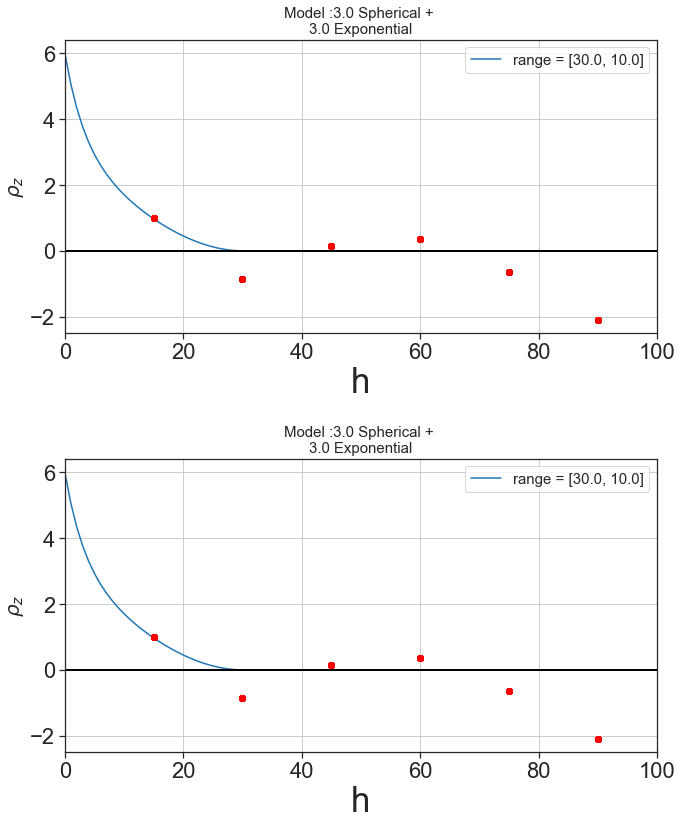

In [2226]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 2
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}


fig, axes = plt.subplots(2,1, figsize=(10, 12))

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(dict_primary["a_max"])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        for j in np.arange(1):
            axes[s].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            if nstruct == 1 :
                
                TITLE = "Model :" +str(dict_primary["cc"][0])+ " " + str(MODEL_name[dict_primary["vtype"][0]])
            else :
                TITLE = "Model :" +str(dict_primary["cc"][0])+ " " + str(MODEL_name[dict_primary["vtype"][0]]) + " + \n" +str(dict_primary["cc"][1])+ " " + str(MODEL_name[dict_primary["vtype"][1]])
            axes[s].set_ylabel(labels_2[i], size=20)
            axes[s].plot(H, ones, color="Black")
            axes[s].set_xlabel("h", size=35)
            axes[s].set_title(TITLE, size=15)
            axes[s].legend(loc="best", prop={"size": 15})
            axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

# Dual Model  (Y)

In [2227]:
varc_2.head()

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
1           2.0         123771.0         0.367115              1.0
2           3.0         243738.0         0.416298              1.0
3           4.0         330006.0         0.459650              1.0
4           5.0         384205.0         0.504366              1.0
5           6.0         465091.0         0.544237              1.0

### Correlogram function  (Y)

In [2228]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

### Minimize function  (Y)

In [2229]:
def optimize_RMSE_Y_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [2230]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([40,70])
a_min_y_0 = np.array([40,70])
cc_y_0    = np.array([2,1])
MODEL_value = np.array([MODEL_type["Spherical"], MODEL_type["Gaussien"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
}

{'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([2., 1.]), 'vtype': array([1, 3], dtype=object)}
RMSE : [1.294143142302461, 1.2733208028575107] 

{'a_max': array([39.99975778, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([2., 1.]), 'vtype': array([1, 3], dtype=object)}
RMSE : [1.2941393894638207, 1.2733208028575107] 

{'a_max': array([40.00024222, 70.        ]), 'a_min': array([40., 70.]), 'cc': array([2., 1.]), 'vtype': array([1, 3], dtype=object)}
RMSE : [1.2941468951278454, 1.2733208028575107] 

{'a_max': array([40., 70.]), 'a_min': array([39.99975778, 70.        ]), 'cc': array([2., 1.]), 'vtype': array([1, 3], dtype=object)}
RMSE : [1.294143142302461, 1.2733171231370635] 

{'a_max': array([40., 70.]), 'a_min': array([40.00024222, 70.        ]), 'cc': array([2., 1.]), 'vtype': array([1, 3], dtype=object)}
RMSE : [1.294143142302461, 1.2733244825635193] 

{'a_max': array([40., 70.]), 'a_min': array([40., 70.]), 'cc': array([1.99998789, 1.        ]), 'vt

RMSE : [0.27008441804257544, 0.27881288975314544] 

{'a_max': array([30.13990189, 67.72014031]), 'a_min': array([30.33201238, 67.88207087]), 'cc': array([1.41553624e+00, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.27008748570658614, 0.27881542671788384] 

{'a_max': array([30.13989972, 67.72014031]), 'a_min': array([30.33201056, 67.88207087]), 'cc': array([1.41553608, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.2700812744511248, 0.27881028378266437] 

{'a_max': array([30.13971721, 67.72014031]), 'a_min': array([30.33201056, 67.88207087]), 'cc': array([1.41553608, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.2700797430746994, 0.27881028378266437] 

{'a_max': array([30.14008223, 67.72014031]), 'a_min': array([30.33201056, 67.88207087]), 'cc': array([1.41553608, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.2700828058293793, 0.27881028378266437] 

{'a_max': array([30.13989972, 67.72014031]), 'a_min': array([30.3318268

RMSE : [0.22557524329186124, 0.2337449611410864] 

{'a_max': array([21.92870235, 67.72014031]), 'a_min': array([23.45428477, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.09654923515136055, 0.1208986497398361] 

{'a_max': array([21.92856956, 67.72014031]), 'a_min': array([23.45428477, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.0965499144298423, 0.1208986497398361] 

{'a_max': array([21.92883513, 67.72014031]), 'a_min': array([23.45428477, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.09654855588178883, 0.1208986497398361] 

{'a_max': array([21.92870235, 67.72014031]), 'a_min': array([23.45414274, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.09654923515136055, 0.12089921371967259] 

{'a_max': array([21.92870235, 67.72014031]), 'a_min': array([23.4544268 , 67.8820

RMSE : [0.09654667964910554, 0.12089596507877992] 

{'a_max': array([21.92870257, 67.72014031]), 'a_min': array([23.45428521, 67.88207087]), 'cc': array([7.92694538e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.09654412540547663, 0.1208932822744631] 

{'a_max': array([21.92870229, 67.72014031]), 'a_min': array([23.45428489, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.0965492354483983, 0.12089864926096953] 

{'a_max': array([21.9285695 , 67.72014031]), 'a_min': array([23.45428489, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.09654991472688434, 0.12089864926096953] 

{'a_max': array([21.92883508, 67.72014031]), 'a_min': array([23.45428489, 67.88207087]), 'cc': array([0.79269454, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.0965485561788223, 0.12089864926096953] 

{'a_max': array([21.92870229, 67.72014031]), 'a_min': array([23.4541428

RMSE : [0.059169488583622615, 0.06243005172820255] 

{'a_max': array([33.82421956, 67.72014031]), 'a_min': array([40.31440513, 67.88207087]), 'cc': array([5.57798457e-01, 7.79310368e-07]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05917035193489761, 0.0624309853514304] 

{'a_max': array([33.82421956, 67.72014031]), 'a_min': array([40.31489338, 67.88207087]), 'cc': array([5.57798457e-01, 7.79310368e-07]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05917035193489761, 0.06242911811388731] 

{'a_max': array([33.82421956, 67.72014031]), 'a_min': array([40.31464926, 67.88207087]), 'cc': array([5.57792401e-01, 7.79310368e-07]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05917169375517022, 0.06243090985854509] 

{'a_max': array([33.82421956, 67.72014031]), 'a_min': array([40.31464926, 67.88207087]), 'cc': array([5.57804512e-01, 7.79310368e-07]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05916901017668874, 0.062429193693951536] 

{'a_max': array([33.82421956, 67.71973023])

RMSE : [0.05459545282140251, 0.06220758559364076] 

{'a_max': array([41.9294679 , 68.24679353]), 'a_min': array([51.6038443 , 69.38719965]), 'cc': array([0.55768673, 0.0503001 ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05459417478322314, 0.062204436320061736] 

{'a_max': array([41.9294679 , 68.24679353]), 'a_min': array([51.6038443 , 69.38719965]), 'cc': array([0.55769884, 0.0503001 ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05459673095879363, 0.06220892287015057] 

{'a_max': array([41.9294679 , 68.24638026]), 'a_min': array([51.6038443 , 69.38719965]), 'cc': array([0.55769278, 0.0503001 ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05459534458642029, 0.06220667956371078] 

{'a_max': array([41.9294679 , 68.24720679]), 'a_min': array([51.6038443 , 69.38719965]), 'cc': array([0.55769278, 0.0503001 ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.05459556105566147, 0.06220667956371078] 

{'a_max': array([41.9294679 , 68.24679353]), 'a_min': array([51.6038443 , 6

{'a_max': array([37.87680233, 67.98346691]), 'a_min': array([45.95918809, 68.63505088]), 'cc': array([0.55774643, 0.02515005]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.04094554515737997, 0.04364150579526738] 

{'a_max': array([37.87680233, 67.98346691]), 'a_min': array([45.95918809, 68.63463527]), 'cc': array([0.55774643, 0.02514399]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.04094557548840306, 0.043640847612775556] 

{'a_max': array([37.87680233, 67.98346691]), 'a_min': array([45.95918809, 68.63463527]), 'cc': array([0.55774643, 0.0251561 ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.04094551528623151, 0.04364220591657223] 

{'a_max': array([37.87680237, 67.98346686]), 'a_min': array([45.95918818, 68.63463529]), 'cc': array([0.55774643, 0.02515005]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.0409455450847217, 0.04364152651758972] 

{'a_max': array([37.87657301, 67.98346686]), 'a_min': array([45.95918818, 68.63463529]), 'cc': array([0.55774643, 0.02515005]), 

RMSE : [0.03876891394097177, 0.04255286214358557] 

{'a_max': array([39.87124575, 66.85652857]), 'a_min': array([48.29131529, 69.36350307]), 'cc': array([0.57931357, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03876891394097177, 0.04255286214358557] 

{'a_max': array([39.87124575, 66.85652857]), 'a_min': array([48.29131529, 69.36434313]), 'cc': array([0.57931357, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03876891394097177, 0.04255286214358557] 

{'a_max': array([39.87124575, 66.85652857]), 'a_min': array([48.29131529, 69.3639231 ]), 'cc': array([5.79313572e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03876886428374533, 0.04255372011838145] 

{'a_max': array([39.87124575, 66.85652857]), 'a_min': array([48.29131529, 69.3639231 ]), 'cc': array([5.79313572e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.038768815104643056, 0.04255457852666844] 

{'a_max': array([39.87124274, 66.85652837]), 'a_min': array

RMSE : [0.039884072380577236, 0.039844718334028535] 

{'a_max': array([41.55516896, 66.91301605]), 'a_min': array([50.03673345, 69.54211835]), 'cc': array([0.55653264, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.039884072380577236, 0.039844718334028535] 

{'a_max': array([41.55516896, 66.91261087]), 'a_min': array([50.03673345, 69.54169724]), 'cc': array([0.55653264, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.039884072380577236, 0.039844718334028535] 

{'a_max': array([41.55516896, 66.91261087]), 'a_min': array([50.03673345, 69.54253946]), 'cc': array([0.55653264, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.039884072380577236, 0.039844718334028535] 

{'a_max': array([41.55516896, 66.91261087]), 'a_min': array([50.03673345, 69.54211835]), 'cc': array([5.56532644e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03988394576014928, 0.039845311203063415] 

{'a_max': array([41.55516896, 66.91261087]), 'a_min': array

{'a_max': array([41.51079071, 66.91043905]), 'a_min': array([49.97607591, 69.53393027]), 'cc': array([0.55790398, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976265644413546, 0.03996000355470005] 

{'a_max': array([41.51079071, 66.91003388]), 'a_min': array([49.97607591, 69.53350921]), 'cc': array([0.55790398, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976265644413546, 0.03996000355470005] 

{'a_max': array([41.51079071, 66.91003388]), 'a_min': array([49.97607591, 69.53435133]), 'cc': array([0.55790398, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976265644413546, 0.03996000355470005] 

{'a_max': array([41.51079071, 66.91003388]), 'a_min': array([49.97607591, 69.53393027]), 'cc': array([5.57903982e-01, 6.05545445e-06]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976256577434086, 0.03996063672147445] 

{'a_max': array([41.51079071, 66.91003388]), 'a_min': array([49.97607591, 69.53393027]), 'cc': array([5.57903982e-01, 1.

{'a_max': array([41.51079098, 66.91003388]), 'a_min': array([49.9760763 , 69.53393027]), 'cc': array([5.57903980e-01, 1.21109089e-05]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976247578556845, 0.039961270144686686] 

{'a_max': array([41.50872517, 66.91003388]), 'a_min': array([49.97940714, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976323718369789, 0.0399594179668724] 

{'a_max': array([41.50847382, 66.91003388]), 'a_min': array([49.97940714, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976323720919505, 0.0399594179668724] 

{'a_max': array([41.50897653, 66.91003388]), 'a_min': array([49.97940714, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.039763237209215624, 0.0399594179668724] 

{'a_max': array([41.50872517, 66.91003388]), 'a_min': array([49.97910449, 69.53393027]), 'cc': array([0.55789724, 0.     

RMSE : [0.03976323721282855, 0.039959417963235926] 

{'a_max': array([41.50897655, 66.91003388]), 'a_min': array([49.97940713, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976323721285505, 0.039959417963235926] 

{'a_max': array([41.50872519, 66.91003388]), 'a_min': array([49.97910449, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976323718733436, 0.03995941798971877] 

{'a_max': array([41.50872519, 66.91003388]), 'a_min': array([49.97970978, 69.53393027]), 'cc': array([0.55789724, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976323718733436, 0.03995941798969782] 

{'a_max': array([41.50872519, 66.91003388]), 'a_min': array([49.97940713, 69.53393027]), 'cc': array([0.55789119, 0.        ]), 'vtype': array([1, 3], dtype=object)}
RMSE : [0.03976376116162591, 0.0399588941774023] 

{'a_max': array([41.50872519, 66.91003388]), 'a_min': array([49.97940713, 6

In [2231]:
dict_secondary

{'a_max': [42.0, 67.0],
 'a_min': [50.0, 70.0],
 'cc': [0.56, 0.0],
 'vtype': array([1, 3])}

### Plot fitted Correlogram (Y)

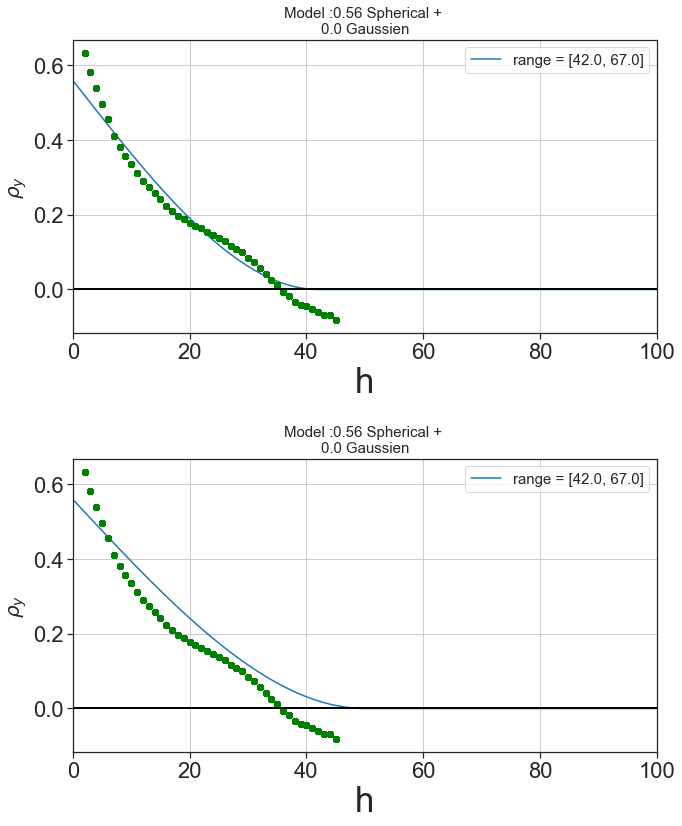

In [2232]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = 2

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}


fig, axes = plt.subplots(2,1, figsize=(10, 12))

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        if s == 0 :
            LABEL =  "range = {}".format(dict_secondary["a_max"])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        for j in np.arange(1):
            axes[s].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            
            if nstruct == 1 :
                
                TITLE = "Model :" +str(dict_secondary["cc"][0])+ " " + str(MODEL_name[dict_secondary["vtype"][0]])
            else :
                TITLE = "Model :" +str(dict_secondary["cc"][0])+ " " + str(MODEL_name[dict_secondary["vtype"][0]]) + " + \n" +str(dict_secondary["cc"][1])+ " " + str(MODEL_name[dict_secondary["vtype"][1]])
            
            axes[s].set_ylabel(labels_2[i], size=20)
            axes[s].plot(H, ones, color="Black")
            axes[s].set_xlabel("h", size=35)
            axes[s].set_title(TITLE, size=15)
            axes[s].legend(loc="best", prop={"size": 15})
            axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

# Cross Model 

### Correlogram function  (Cross)

In [2233]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### Minimize function  (Cross)

In [2234]:
def optimize_RMSE_ZY_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] à la Sill_value
    gamma= b*spherical(a_min,a_max)
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2]
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [2235]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

Primary = Cross_variogram["DataFrame"]
corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([60])
a_min_zy_0  = np.array([60])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Gaussien"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(single_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
}

Coeff de correlation : 0.26
{'a_max': array([60.]), 'a_min': array([60.]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076986580141944, 0.9076986580141944] 

{'a_max': array([59.99963667]), 'a_min': array([60.]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076984849097309, 0.9076986580141944] 

{'a_max': array([60.00036333]), 'a_min': array([60.]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076988311223534, 0.9076986580141944] 

{'a_max': array([60.]), 'a_min': array([59.99963667]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076986580141944, 0.9076984849097309] 

{'a_max': array([60.]), 'a_min': array([60.00036333]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076986580141944, 0.9076988311223534] 

{'a_max': array([59.99999982]), 'a_min': array([59.99999982]), 'cc': [0.26], 'vtype': array([3.0], dtype=object)}
RMSE : [0.9076986579273227, 0.9076986579273227] 

{'a_max': array([59.99963649]), 'a_m

In [2236]:
dict_cross

{'a_max': [35.0], 'a_min': [35.0], 'cc': [0.26], 'vtype': array([3])}

### Plot fitted Cross Correlogram

In [2237]:
var

Lag Distance  Number of Pairs  Variogram Value  Variogram Index
0             15              9.0         0.000000              1.0
1             30              3.0         0.394334              1.0
2             45              2.0         0.080222              1.0
3             60              7.0         1.413716              1.0
4             75              4.0         2.092032              1.0
5             90              2.0         0.622794              1.0
6             15              9.0         0.000000              2.0
7             30              3.0         0.394334              2.0
8             45              2.0         0.080222              2.0
9             60              7.0         1.413716              2.0
10            75              4.0         2.092032              2.0
11            90              2.0         0.622794              2.0

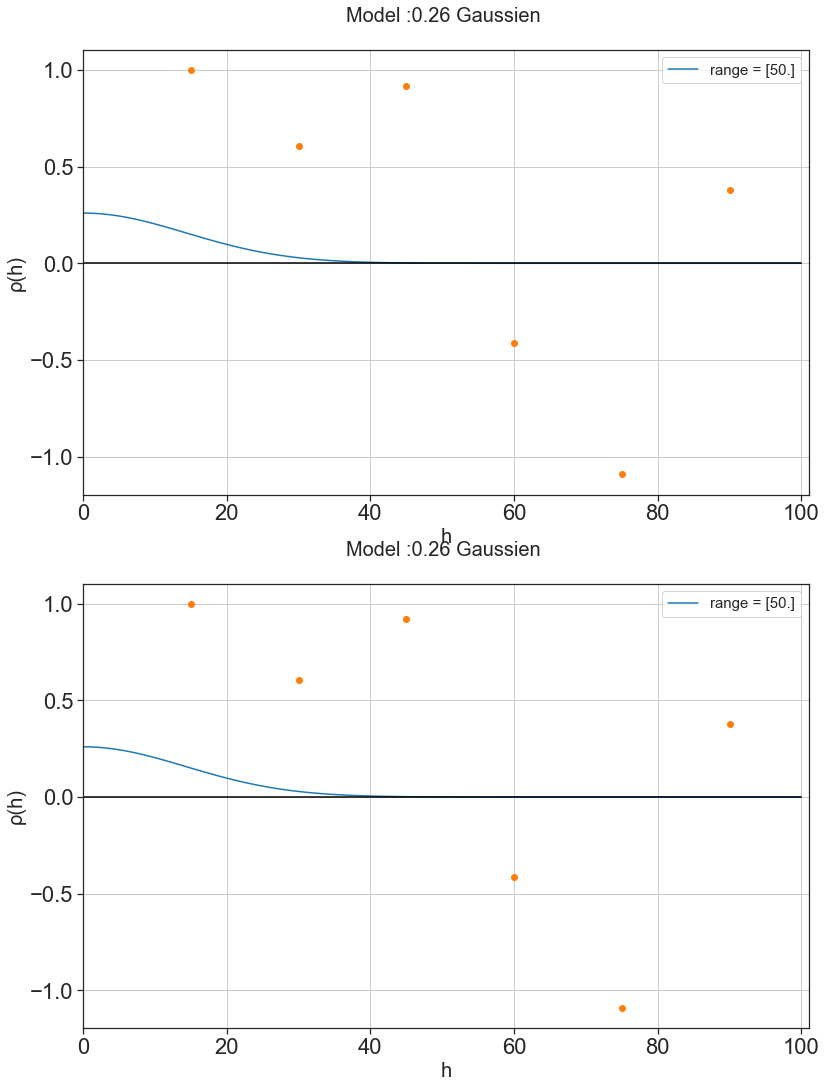

In [2238]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
k = 0
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien"}

fig, axes = plt.subplots(2, 1, figsize=(13, 18))

for Dir in Direction:
    
    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        if Dir == "Major" : 
            LABEL =  "range = {}".format(a_max[0])
        axes[k].plot(H, MM_vargs[i], label=LABEL)
        
        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[k].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o"
                )
    
    TITLE = "Model :"
    for i in range(len([cc_zy])) :
        name = MODEL_name[dict_cross["vtype"][0]]
        TITLE += f"{cc_zy[0]} {name} " + "\n"
        
    axes[k].plot(H, ones, color="Black")
    axes[k].grid()
    axes[k].set_xlim(0, LENGTH + 1)
    #axes[k].set_ylim(-0.1, 1)
    axes[k].set_ylabel("\u03C1(h)", size=20)
    axes[k].set_xlabel("h", size=20)
    axes[k].set_title(TITLE,size=20)
    axes[k].legend(loc="best", prop={"size": 15})
    varg_type_cc = varg_type_cc + 1
    k +=1
    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

## Set up MMII Correlogram

In MMII the secondary correlogram ρy(h) and the correlation are used to calculate the secondary covariance and the cross covariance. In MMII the primary covariance is fit using ρr(h) and the secondary correlogram ρy(h). The primary correlogram for the MMII is denoted as ρzMMII(h) in the images below. ρzMMII(h) should be similar to ρz(h)

#### Le modèle ρzMMII doit similaire à ρz(h) : On passe obligatoirement par une fonction de minimisation 

### Scalling Correlogram

In [2239]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z Correlogram MMII 

In [2240]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 2) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

### Minimize function

In [2241]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram ce C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 2)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 2)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [2242]:
a = dict_secondary["vtype"]

In [2243]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([40])
a_min_r_0 = np.array([40])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [40.0], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': [2.0], 'vtype': [1]}
{'a_max': [40.0], 'a_min': [40.000242218178094], 'cc': [2.0], 'vtype': [1]}
{'a_max': [40.0], 'a_min': [40.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [40.0], 'a_min': [40.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [40.0000001773571], 'a_min': [40.00000017255902], 'cc': [2.000000099855516], 'vtype': [1]}
{'a_max': [39.999757959177934], 'a_min': [40.00000017255902], 'cc': [2.000000099855516], 'vtype': [1]}
{'a_max': [40.00024239553627], 'a_min': [40.00000017255902], 'cc': [2.000000099855516], 'vtype': [1]}
{'a_max': [40.0000001773571], 'a_min': [39.99975795437988], 'cc': [2.000000099855516], 'vtype': [1]}
{'a_max': [40.0000001773571], 'a_min': [40.00024239073816], 'cc': [2.0000

{'a_max': [22.263079224758776], 'a_min': [21.34677137160875], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.263079224758776], 'a_min': [21.34664210798975], 'cc': [4.999969722727738], 'vtype': [1]}
{'a_max': [22.263079224758776], 'a_min': [21.34664210798975], 'cc': [4.999939445455476], 'vtype': [1]}
{'a_max': [22.574964877654537], 'a_min': [23.815930054596755], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.574828175982955], 'a_min': [23.815930054596755], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.57510157932612], 'a_min': [23.815930054596755], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.574964877654537], 'a_min': [23.81578583831707], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.574964877654537], 'a_min': [23.81607427087644], 'cc': [5.0], 'vtype': [1]}
{'a_max': [22.574964877654537], 'a_min': [23.815930054596755], 'cc': [4.999969722727738], 'vtype': [1]}
{'a_max': [22.574964877654537], 'a_min': [23.815930054596755], 'cc': [4.999939445455476], 'vtype': [1]}
{'a_max': [22.574966159929026], 'a_min': [23.81592

## Data Statistics

In [2244]:
Primary

SensorName           x            y      T3   Primary  Pseudo_temp  \
0        S10   523628.71   5366296.81  10.030  1.528289     9.199116   
1         S1   523654.74   5366287.75   9.197  0.080528     6.857671   
2         S9   523692.47   5366276.57   9.415  0.459414     5.911915   
3         S2   523660.22   5366258.91   8.649 -0.871901     7.403057   
4         S4  523636.075  5366245.545   9.731  1.008625     9.382530   
5         S5  523641.825   5366220.67   8.099 -1.827806     8.213127   
6         S8   523649.33   5366188.02   9.148 -0.004635     8.486796   
7         S7  523696.655    5366174.0   9.500  0.607145     4.852900   
8         S6   523694.05   5366209.93   8.587 -0.979658     4.297738   

   Secondary  
0   1.162678  
1  -0.184485  
2  -0.728632  
3   0.129306  
4   1.268207  
5   0.595384  
6   0.752841  
7  -1.337942  
8  -1.657357

In [2245]:
Mean_Z = np.average(Primary["Primary"])
STD_Z = Primary["Primary"].std()
print(Mean_Z)
print(STD_Z)

3.4540271877227093e-16
1.0606601717798214


In [2246]:
Mean_Y = np.average(Secondary["Secondary"])
STD_Y =  Secondary["Secondary"].std()
print(Mean_Y)
print(STD_Y)

0.001150272190972465
0.9936793686514025


## Create a KDTree to Quickly Get Nearest Points

In [2247]:
from sklearn.neighbors import KDTree

In [2248]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    
    return low_quality_secondary,x_ech,y_ech,z_ech

In [2249]:
Secondary.head()

X             Y    band 1  cluster_label_vis  val_cluster_hsv  \
0  523628.71  5.366174e+06  7.034997                2.0              0.0   
1  523628.71  5.366175e+06  7.159491                2.0              0.0   
2  523628.71  5.366175e+06  7.542570                3.0              0.0   
3  523628.71  5.366176e+06  7.740776                5.0              0.0   
4  523628.71  5.366177e+06  7.329526                1.0              0.0   

   Secondary  
0  -0.104540  
1  -0.013046  
2   0.268489  
3   0.414155  
4   0.111917

In [2250]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
ech = 1
df_kriging,x_ech,y_ech,z_ech = ech_data_kdtree(x,y,z,ech)

In [2251]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary[["x", "y"]].values
datafl = Primary
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

In [2252]:
condition = False
if condition :
    # Aperçu de la zone d'étude 
    fig,ax=plt.subplots(1,2, figsize = (15,10))
    img0 = ax[0].scatter(x_ech, y_ech,c = z_ech , vmin = -3, vmax = 3)
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].grid()
    ax[0].set_title("Données échantillonée, ech = " + str(ech))
    fig.colorbar(img0, ax=ax[0])

    img0 = ax[1].scatter(x,y,c = z,vmin = -3, vmax = 3)
    ax[1].set_xlabel('X')
    ax[1].set_ylabel('Y')
    ax[1].grid()
    fig.colorbar(img0, ax=ax[1])


### Primary Data Search for Kriging

In [2253]:
k_p = 8  # number of data to use ( limitée au nombre de sonde = 9)
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["x", "y"]]

### Secondary Data Search for CoKriging

In [2254]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

## Recap des models de variogrammes

In [2255]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [30.0, 10.0], 'a_min': [30.0, 10.0], 'cc': [3.0, 3.0], 'vtype': array([1, 2])}


In [2256]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [42.0, 67.0], 'a_min': [50.0, 70.0], 'cc': [0.56, 0.0], 'vtype': array([1, 3])}


In [2257]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [35.0], 'a_min': [35.0], 'cc': [0.26], 'vtype': array([3])}


In [2258]:
print("Scalling Correlogram ") 
print(dict_scalling)

Scalling Correlogram 
{'a_max': [23.0], 'a_min': [23.0], 'cc': [5.0], 'vtype': array([1])}


## Simple Kriging

In [2259]:
est_SK = np.zeros(shape=(len(x_ech)))

for z in tqdm(range(0, len(x_ech))):
    Kriging_Matrix = np.zeros(shape=((k_p, k_p)))
    # h = distance_matrix(X_Y[z,:,:].tolist(),X_Y[z,:,:].tolist())
    # C_ZZ
    Kriging_Matrix = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 2 )
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((k_p)),((k_p))))
    r = np.zeros(shape=(k_p))
    k_p_weights = r
    # RHS #C_z*
    r = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 2 )
    Kriging_Matrix.reshape(((k_p)), ((k_p)))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_SK[z] = 0
    # add in mean_z
    est_SK[z] = est_SK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_SK[z] = est_SK[z] + k_weights[i] * (
            closematrix_Primary[z, i] - Mean_Z
        )

100%|████████████████████████████████████████████████████████████████████████| 317337/317337 [02:24<00:00, 2199.52it/s]


## Full Cokriging

In [2260]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary, nstruct = 2)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross, nstruct = 1)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross, nstruct = 1)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary, nstruct = 2 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary, nstruct = 2 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross, nstruct = 1)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████| 317337/317337 [05:20<00:00, 988.82it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM1

In [2261]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM1 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,dict_primary, nstruct = 2 )
    # C_ZY
    czy = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,dict_primary, nstruct = 2 ) * corr
    # C_YY
    cy = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,dict_primary, nstruct = 2 )
    # Set up Right Hand Side
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    r[0:k] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,dict_primary, nstruct = 2 )
    # RHS #C_yz*
    r[k : k * 2] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,dict_primary, nstruct = 2 ) * corr
    )
    # RHS corr
    r[k * 2] = corr
    # Dans le cas du MM1, le Kriging_Matrix est calculé par rapport au correlogram C_Z et0 du facteur de cor
    # c_zy 
    Kriging_Matrix[k * 2, 0:k] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,dict_primary, nstruct = 2) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,dict_primary, nstruct = 2) * corr
    )
    # c_z
    Kriging_Matrix[k * 2, k : k * 2] = C_Z_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    ,dict_primary, nstruct = 2)
    Kriging_Matrix[k : k * 2, k * 2] = C_Z_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1
    ,dict_primary, nstruct = 2 )
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM1[z] = 0
    # add in mean_z
    est_icck_MM1[z] = est_icck_MM1[z] + Mean_Z
    # add in the Y_0
    est_icck_MM1[z] = (
        est_icck_MM1[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM1[z] = (
            est_icck_MM1[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████| 317337/317337 [10:22<00:00, 509.50it/s]

There where 0 Singular Matrices


## Intrinsic Collocated Cokriging - MM2

In [2262]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 2)
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 2)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 2) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 2) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 2) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 2)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 2)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

100%|█████████████████████████████████████████████████████████████████████████| 317337/317337 [11:48<00:00, 447.95it/s]

There where 0 Singular Matrices


##  Setup Dictionary of Results

In [2263]:
ktypes = ["SK", "SCK","ICC_MM1","ICC_MM2"]
k_est = [
    est_SK,
    est_Full_CCK,
    est_icck_MM1,
    est_icck_MM2
]
ktypes_vals_dict = {}
j = 0
for i in ktypes:
    
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
    }
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    df_kriging["cluster_label_vis"] = Secondary["cluster_label_vis"]
    df_kriging["val_cluster_hsv"] = Secondary["val_cluster_hsv"]
    j = j + 1

In [2264]:
df_kriging

x             y         z  NS_Estimate_SK  Estimate_SK  \
0       523628.710  5.366174e+06 -0.104540       -0.000104     9.150603   
1       523628.710  5.366175e+06 -0.013046       -0.000115     9.150597   
2       523628.710  5.366175e+06  0.268489       -0.000126     9.150590   
3       523628.710  5.366176e+06  0.414155       -0.000137     9.150583   
4       523628.710  5.366177e+06  0.111917       -0.000148     9.150576   
...            ...           ...       ...             ...          ...   
317332  523696.655  5.366295e+06 -2.158290        0.045697     9.178554   
317333  523696.655  5.366295e+06 -2.094422        0.042050     9.176328   
317334  523696.655  5.366296e+06 -2.001790        0.038536     9.174184   
317335  523696.655  5.366296e+06 -2.088947        0.035158     9.172123   
317336  523696.655  5.366297e+06 -1.999850        0.031917     9.170145   

        cluster_label_vis  val_cluster_hsv  NS_Estimate_SCK  Estimate_SCK  \
0                     2.0              0.0        -0.019911      9.138515   
1                     2.0              0.0        -0.005966      9.147026   
2                     3.0              0.0         0.055242      9.184379   
3                     5.0              0.0         0.124882      9.226878   
4                     1.0              0.0         1.223205      9.897156   
...                   ...              ...              ...           ...   
317332                3.0              2.0        -0.907646      8.596755   
317333                2.0              2.0        -0.921691      8.588183   
317334                3.0              2.0        -0.889180      8.608024   
317335                3.0              5.0        -0.908400      8.596294   
317336                3.0              5.0        -0.884820      8.610685   

        NS_Estimate_ICC_MM1  Estimate_ICC_MM1  NS_Estimate_ICC_MM2  \
0                 -0.032180          9.131028            -0.027654   
1                 -0.008708          9.145353            -0.003714   
2                  0.064481          9.190018             0.069950   
3                  0.102115          9.212985             0.108064   
4                  0.022549          9.164428             0.028983   
...                     ...               ...                  ...   
317332            -0.502949          8.843730            -0.508098   
317333            -0.491192          8.850905            -0.501701   
317334            -0.471728          8.862784            -0.486995   
317335            -0.499122          8.846066            -0.519183   
317336            -0.480211          8.857607            -0.503568   

        Estimate_ICC_MM2  
0               9.133790  
1               9.148400  
2               9.193355  
3               9.216615  
4               9.168354  
...                  ...  
317332          8.840588  
317333          8.844492  
317334          8.853467  
317335          8.833824  
317336          8.843353  

[317337 rows x 13 columns]

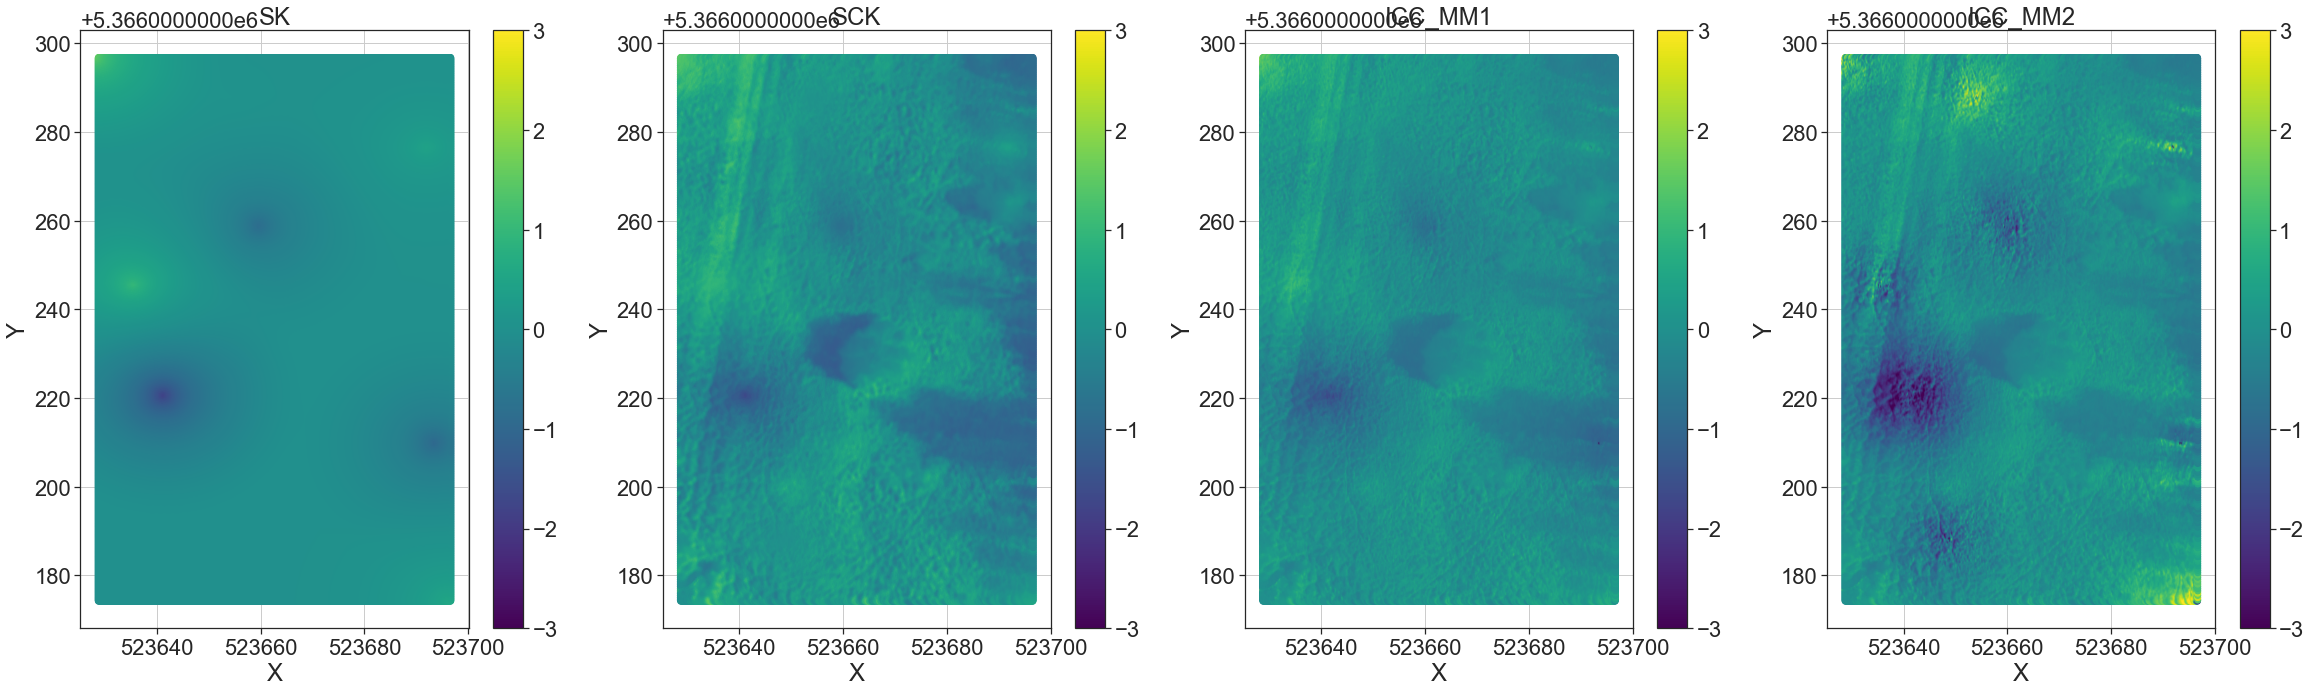

In [2265]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,4, figsize = (40,11))
for i,types in enumerate(ktypes) :
    Z = df_kriging["NS_Estimate_"+types].values
    
    img0 = ax[i].scatter(x_ech, y_ech,c = Z , vmin = -3, vmax = 3, cmap = "viridis")
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].grid()
    ax[i].set_title(types)
    fig.colorbar(img0, ax=ax[i])

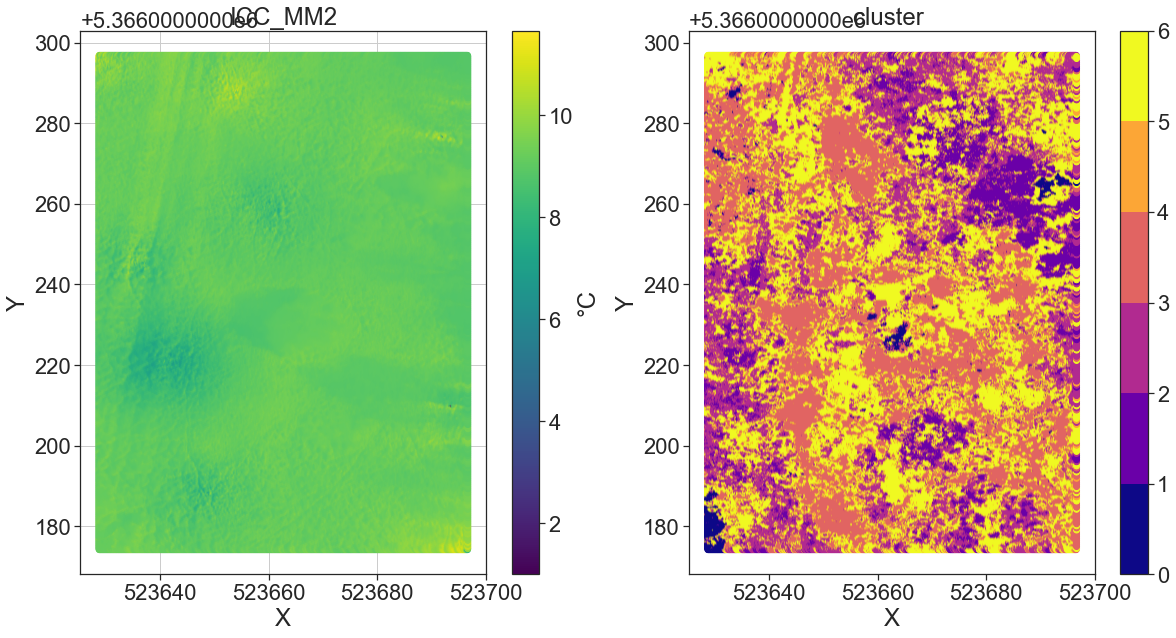

In [2266]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,2, figsize = (20,10))
types = "ICC_MM2"
Z = df_kriging["Estimate_"+types].values
cluster = Secondary["val_cluster_hsv"].values
psm = cm.get_cmap('plasma',6)

img0 = ax[0].scatter(x_ech, y_ech,c = Z,vmin = 1,cmap = "viridis")
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid()
ax[0].set_title(types)
fig.colorbar(img0, ax=ax[0], label = "°C")

img1 = ax[1].scatter(x_ech, y_ech,c = cluster, cmap = psm )
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title("cluster ")
fig.colorbar(img1, ax=ax[1])

In [2267]:
df_kriging.keys()

Index(['x', 'y', 'z', 'NS_Estimate_SK', 'Estimate_SK', 'cluster_label_vis',
       'val_cluster_hsv', 'NS_Estimate_SCK', 'Estimate_SCK',
       'NS_Estimate_ICC_MM1', 'Estimate_ICC_MM1', 'NS_Estimate_ICC_MM2',
       'Estimate_ICC_MM2'],
      dtype='object')

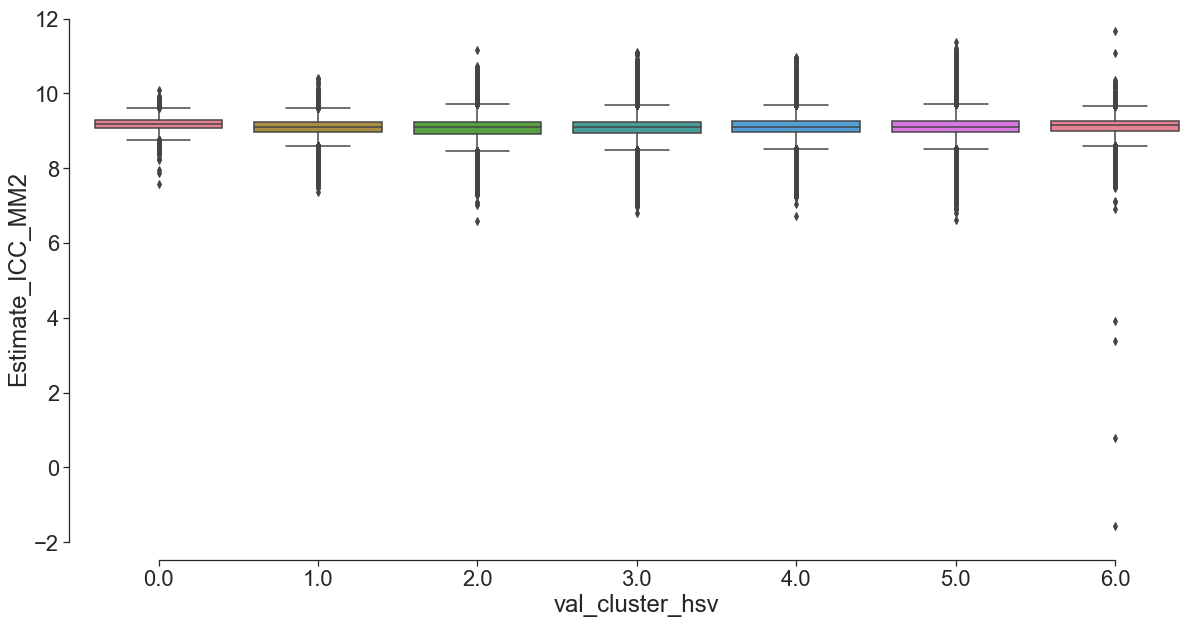

In [2268]:
fig,ax=plt.subplots(1,1, figsize = (20,10))
with sns.color_palette("husl") as cmap :
    data = df_kriging
    sns.boxplot(x='val_cluster_hsv',y="Estimate_ICC_MM2",
               data = data,palette = cmap,ax = ax )
    sns.set_theme(style="ticks",font_scale = 2)
    sns.despine(offset=10, trim=True)

In [2269]:
print("Z max :",Z.max())
print("Z min :",Z.min())
print("Z mean :",Z.mean())

Z max : 11.660012881688885
Z min : -1.5603888619660466
Z mean : 9.081737597984253


# RMSE et Validation

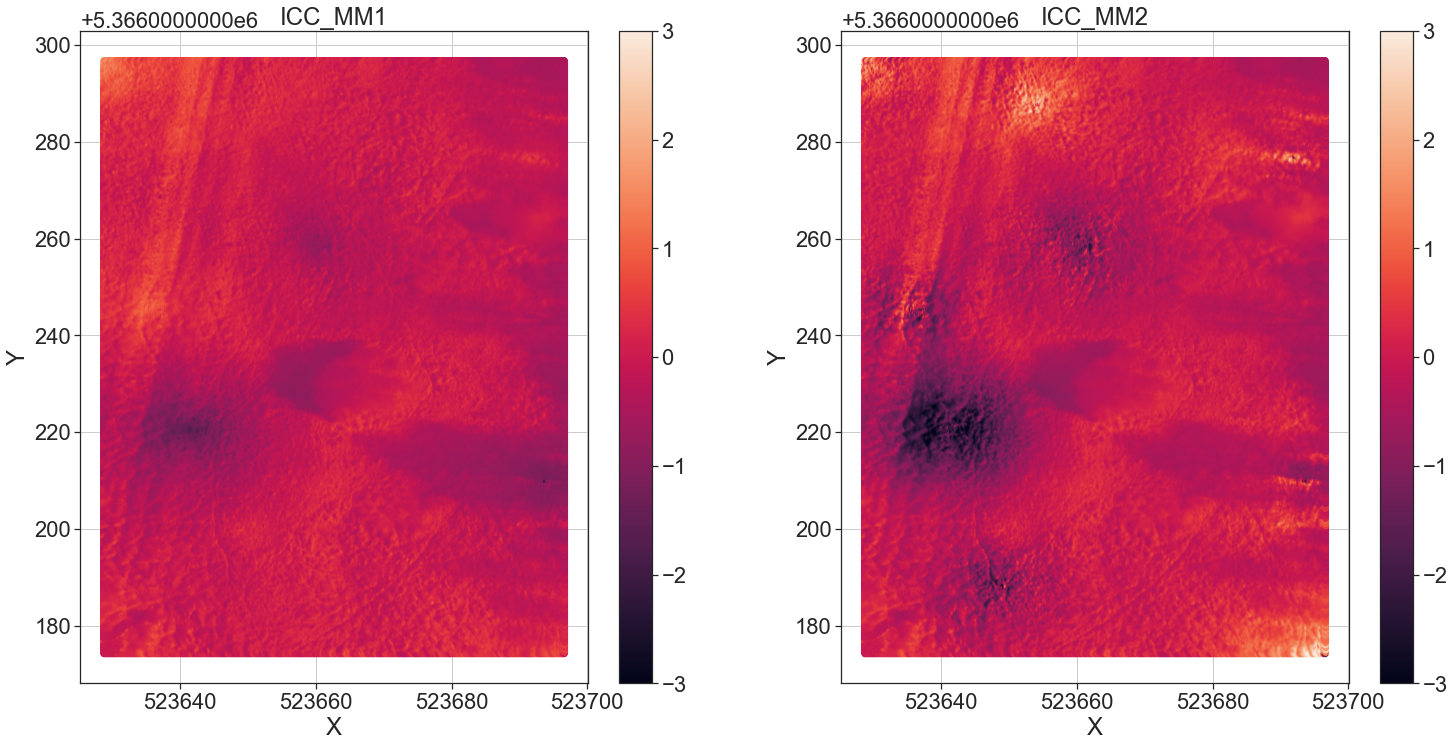

In [2270]:
fig,ax=plt.subplots(1,2, figsize = (25,12))
for i,types in enumerate(["ICC_MM1","ICC_MM2"]) :
    df_kriging["Estimate_"+types] = ktypes_vals_dict[types]["Estimate"] 
    Z = df_kriging["Estimate_"+types].values
    
    img0 = ax[i].scatter(x_ech, y_ech,c = Z , vmin =-3 , vmax = 3)
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('Y')
    ax[i].grid()
    ax[i].set_title(types)
    fig.colorbar(img0, ax=ax[i])

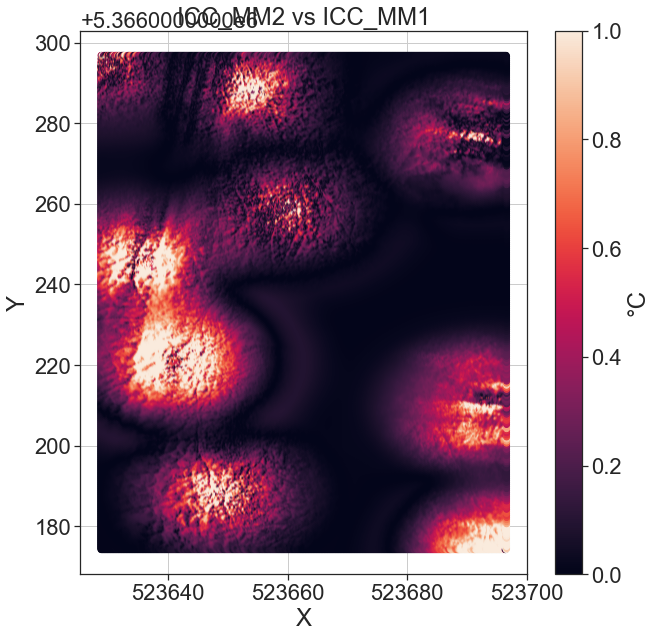

In [2271]:
# Aperçu de la zone d'étude 
## * original_variance_z + original_mean_z
fig,ax=plt.subplots(1,1, figsize = (10,10))
type_1 = "ICC_MM2"
type_2 = "ICC_MM1"
Z_1 = df_kriging["Estimate_"+type_1] = ktypes_vals_dict[type_1]["Estimate"]
Z_2 = df_kriging["Estimate_"+type_2] = ktypes_vals_dict[type_2]["Estimate"]
Z = np.absolute(Z_2-Z_1)

img0 = ax.scatter(x_ech, y_ech,c = Z , vmin = 0 ,vmax = 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.set_title(type_1 + " vs " + type_2)
fig.colorbar(img0, ax=ax, label = "°C")

In [2276]:
dict_IR_9H54[TEMP] = {"dict_primary" : dict_primary,
                      "dict_secondary" : dict_secondary,
                      "dict_cross" : dict_cross,
                      "dict_scalling" : dict_scalling,
                     "cokriging" : df_kriging,
                     "std_z" :original_std_z,
                     "mean_z" : original_mean_z,
                     "std_y" :original_std_y,
                     "mean_y" : original_mean_y}

fileout = "./varr/Kriging/" + str(REQUESTED_IR)+ "_" + TEMP + ".npy"

In [2277]:
np.save(fileout,dict_IR_9H54[TEMP])

# Comparaison T4 - T3 - T2 - T1

In [1386]:
dict_IR_9H54.keys()

dict_keys(['T4', 'T3', 'T2', 'T1'])

SensorName           x            y      T1   Primary
0        S10   523628.71   5366296.81  11.006  1.435718
1         S1   523654.74   5366287.75  10.510  0.467145
2         S9   523692.47   5366276.57  10.374  0.201569
3         S2   523660.22   5366258.91   9.631 -1.249337
4         S4  523636.075  5366245.545  10.863  1.156472
5         S5  523641.825   5366220.67   9.907 -0.710373
6         S8   523649.33   5366188.02  10.153 -0.229993
7         S7  523696.655    5366174.0  10.586  0.615556
8         S6   523694.05   5366209.93   9.407 -1.686757

In [1453]:
max(Z)

13.845994244206322

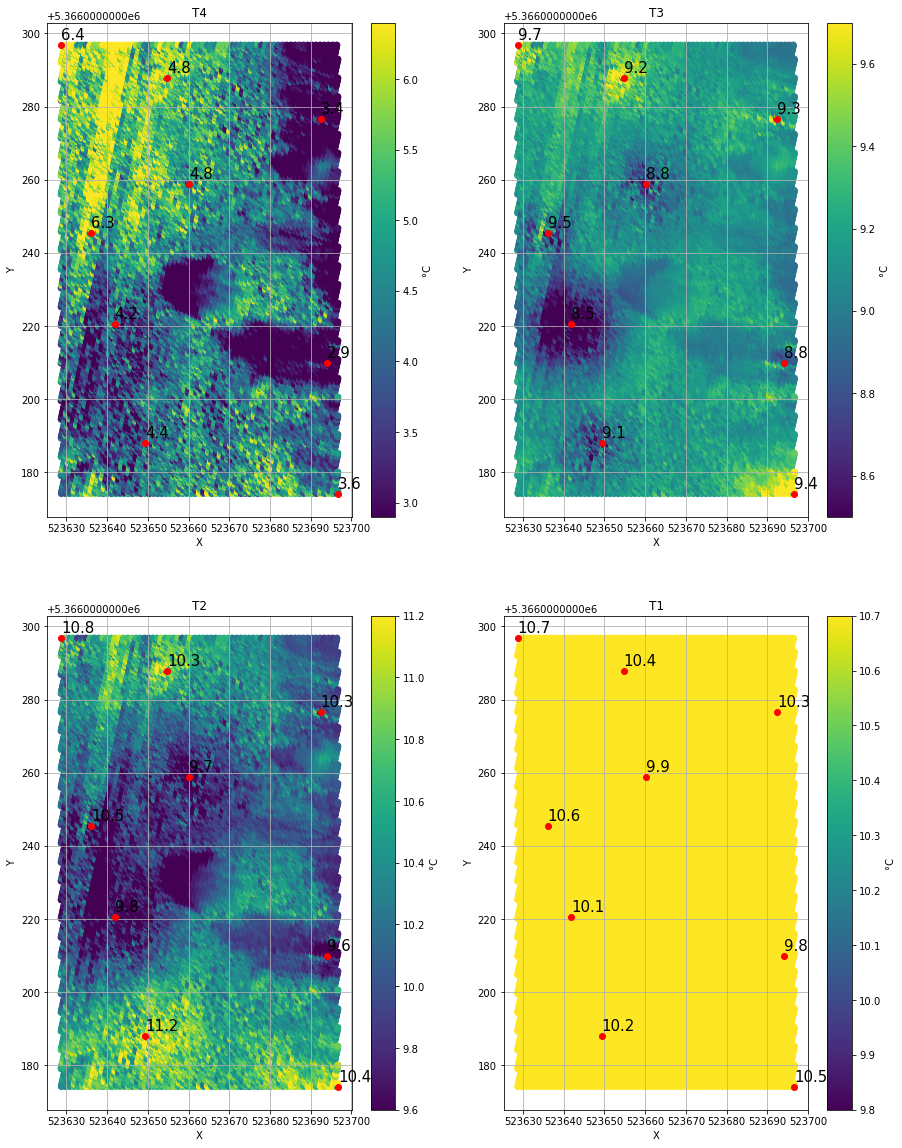

In [1455]:
fig,ax=plt.subplots(2,2,figsize = (15,20))
i,k = 0,0
for temp in dict_IR_9H54 :
    Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,temp,"Primary") 
    original_variance_z = dict_IR_9H54[temp]["variance"] 
    original_mean_z = dict_IR_9H54[temp]["mean"]
    types = "ICC_MM2"
    Z = dict_IR_9H54[temp]["cokriging"]["Estimate_"+types].values* original_variance_z + original_mean_z
    
    Target_x = np.array(Primary_variogram["DataFrame"]["x"],dtype = float)
    Target_y = np.array(Primary_variogram["DataFrame"]["y"],dtype = float)
    sensor_value = [float("{:.1f}".format(x)) for x in np.array(Primary_variogram["DataFrame"]["Primary"],dtype = float)* original_variance_z + original_mean_z]
    img0 = ax[i][k].scatter(x_ech, y_ech,c = Z , vmin = min(sensor_value), vmax = max(sensor_value))
    ax[i][k].plot(Target_x,Target_y,"ro")
    for kk in range(len(Target_x)) :
        ax[i][k].text(Target_x[kk],Target_y[kk]+1.5,sensor_value[kk], size = 15)
        
    ax[i][k].set_xlabel('X')
    ax[i][k].set_ylabel('Y')
    ax[i][k].grid()
    ax[i][k].set_title(temp)
    fig.colorbar(img0, ax=ax[i][k], label = "°C")
    
    k += 1
    if k == 2 :
        k = 0
        i += 1

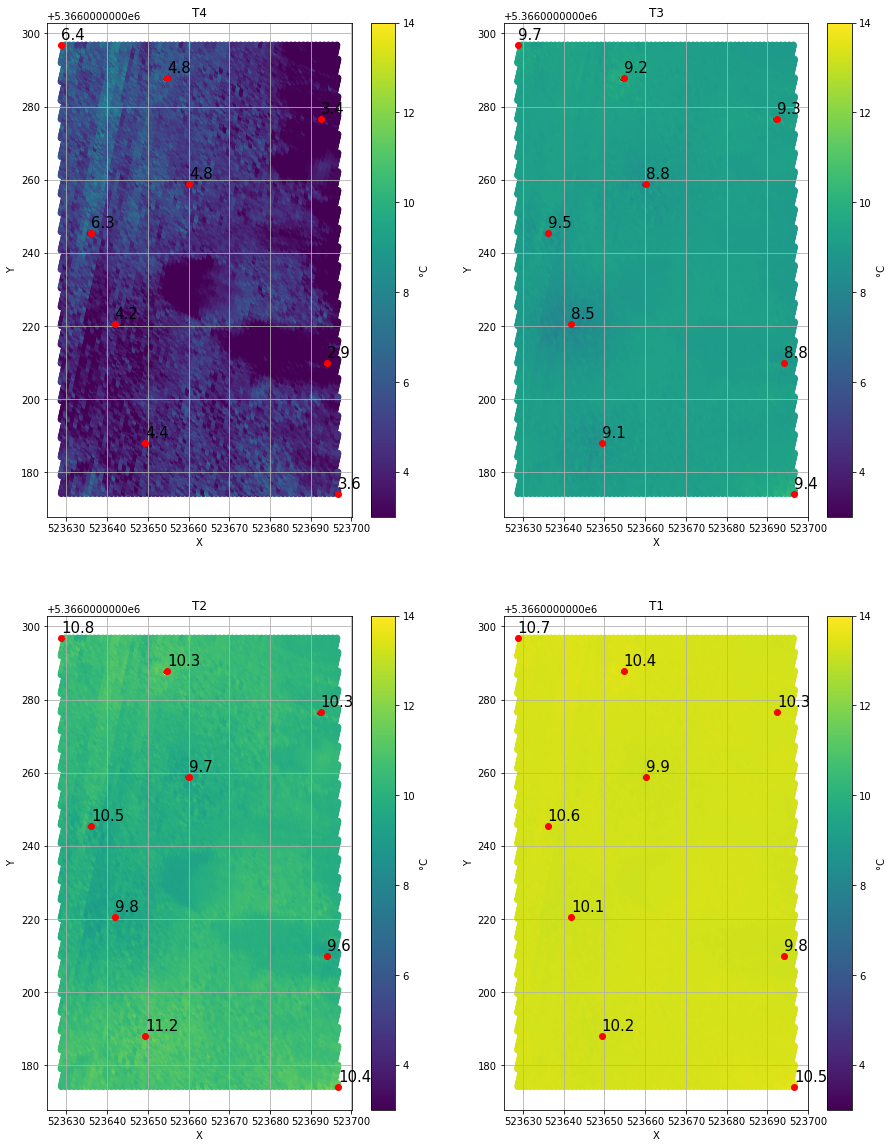

In [1460]:
fig,ax=plt.subplots(2,2,figsize = (15,20))
i,k = 0,0
for temp in dict_IR_9H54 :
    Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,temp,"Primary") 
    original_variance_z = dict_IR_9H54[temp]["variance"] 
    original_mean_z = dict_IR_9H54[temp]["mean"]
    types = "ICC_MM2"
    Z = dict_IR_9H54[temp]["cokriging"]["Estimate_"+types].values* original_variance_z + original_mean_z
    
    Target_x = np.array(Primary_variogram["DataFrame"]["x"],dtype = float)
    Target_y = np.array(Primary_variogram["DataFrame"]["y"],dtype = float)
    sensor_value = [float("{:.1f}".format(x)) for x in np.array(Primary_variogram["DataFrame"]["Primary"],dtype = float)* original_variance_z + original_mean_z]
    img0 = ax[i][k].scatter(x_ech, y_ech,c = Z , vmin = 3, vmax = 14)
    ax[i][k].plot(Target_x,Target_y,"ro")
    for kk in range(len(Target_x)) :
        ax[i][k].text(Target_x[kk],Target_y[kk]+1.5,sensor_value[kk], size = 15)
        
    ax[i][k].set_xlabel('X')
    ax[i][k].set_ylabel('Y')
    ax[i][k].grid()
    ax[i][k].set_title(temp)
    fig.colorbar(img0, ax=ax[i][k], label = "°C")
    
    k += 1
    if k == 2 :
        k = 0
        i += 1

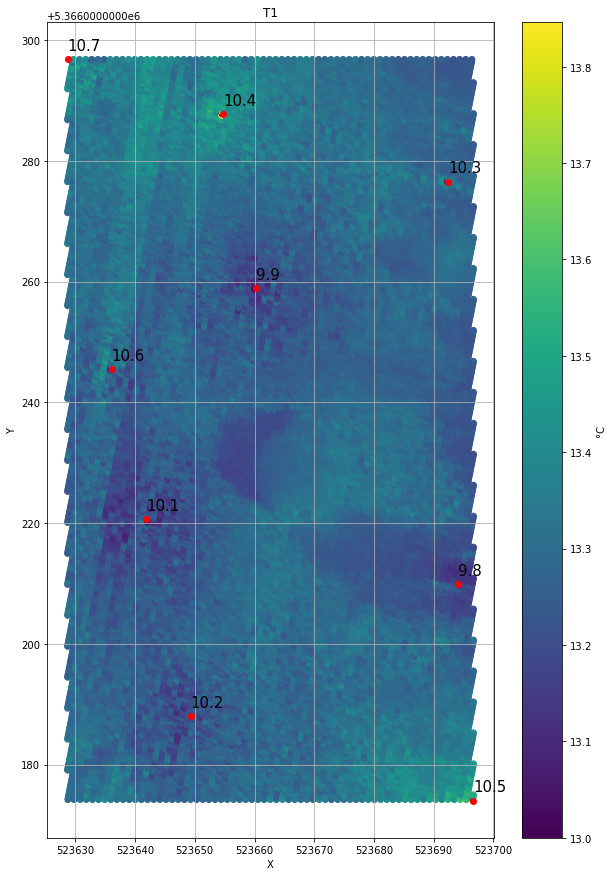

In [1459]:
fig,ax=plt.subplots(1,1,figsize = (10,15))
i,k = 0,0
temp = "T1"
Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,temp,"Primary") 
original_variance_z = dict_IR_9H54[temp]["variance"] 
original_mean_z = dict_IR_9H54[temp]["mean"]
types = "ICC_MM2"
Z = dict_IR_9H54[temp]["cokriging"]["Estimate_"+types].values* original_variance_z + original_mean_z

Target_x = np.array(Primary_variogram["DataFrame"]["x"],dtype = float)
Target_y = np.array(Primary_variogram["DataFrame"]["y"],dtype = float)
sensor_value = [float("{:.1f}".format(x)) for x in np.array(Primary_variogram["DataFrame"]["Primary"],dtype = float)* original_variance_z + original_mean_z]
img0 = ax.scatter(x_ech, y_ech,c = Z, vmin = 13)
ax.plot(Target_x,Target_y,"ro")
for kk in range(len(Target_x)) :
    ax.text(Target_x[kk],Target_y[kk]+1.5,sensor_value[kk], size = 15)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.set_title(temp)
fig.colorbar(img0, ax=ax, label = "°C")

In [ ]:
gridded = np.reshape(
    df_kriging.sort_values(by=["x", "y"], axis=0, ascending=True)[
        "Estimate_ICC_MM2"
    ].values,
    [width,height],
    order="C")